In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.13.0
Keras version: 2.13.1


In [2]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, Flatten, Input,  Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras import metrics
import tensorflow.keras.backend as K


# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.metrics import (classification_report, confusion_matrix,mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, roc_auc_score)
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import load_model



# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline


## Carga de Datos y Preparación de Conjuntos

In [3]:
X_train_ae = pd.read_csv(r"../Datos/MultiTrainBalanced.csv")
X_test_ae  = pd.read_csv(r"../Datos/MultiTest1Balanced.csv")

In [4]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train_ae.shape[0])
Y_train_ae = X_train_ae['CLASS_LABEL']
X_train_ae = X_train_ae.drop(['CLASS_LABEL'], axis=1)
print(X_train_ae.shape, Y_train_ae.shape)

print("\n\t\tDatos de prueba AE")
nr_clases = X_test_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test_ae.shape[0])
Y_test_ae = X_test_ae['CLASS_LABEL']
X_test_ae = X_test_ae.drop(['CLASS_LABEL'], axis=1)
print(X_test_ae.shape, Y_test_ae.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
2    5492
1    5442
4    5434
0    5392
3    5382
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
2    20.234323
1    20.050107
4    20.020632
0    19.865891
3    19.829047
Name: count, dtype: float64
(27142, 606) (27142,)

		Datos de prueba AE

Cantidad  CLASS_LABEL
3    1189
0    1182
4    1167
2    1153
1    1125
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
3    20.443604
0    20.323246
4    20.065337
2    19.824622
1    19.343191
Name: count, dtype: float64
(5816, 606) (5816,)


## Construcción y Configuración del Modelo

### Definición del Modelo:
#### Dimensiones:
- **Entrada (`dim_entrada`)**: **606** características (dimensión de las características en `X_train_ae`).
- **Espacio Latente (`latent_dim`)**: **20** dimensiones para representar las características codificadas.

#### Salidas del Modelo:
- **Reconstrucción (`output_AE`)**:
  - Salida para la tarea de reconstrucción (autoencoder).
- **Clasificación (`output_classifier`)**:
  - Salida para la tarea de clasificación binaria.

### Compilación del Modelo:
- **Optimizador**: Adam con tasa de aprendizaje **0.001**.
- **Funciones de Pérdida**:
  - Reconstrucción: `mse` (Error Cuadrático Medio).
  - Clasificación: `binary_crossentropy` (Entropía Cruzada Binaria).
- **Pesos de las Pérdidas**:
  - Reconstrucción: **1.0**.
  - Clasificación: **0.1**.
- **Métricas**:
  - Reconstrucción: `mae` (Error Absoluto Medio).
  - Clasificación: `accuracy`.

El modelo combina un autoencoder para la reconstrucción de datos y un clasificador binario en una sola arquitectura.


In [5]:
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas de entrenamiento y prueba
Y_train_ae_cod = to_categorical(Y_train_ae)
Y_test_ae_cod = to_categorical(Y_test_ae)

# Mostrar las dimensiones resultantes
print("Dimensiones de Y_train_one_hot:", Y_train_ae_cod.shape)
print("Dimensiones de Y_test_one_hot:", Y_test_ae_cod.shape)

Dimensiones de Y_train_one_hot: (27142, 5)
Dimensiones de Y_test_one_hot: (5816, 5)


In [6]:
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    # Asegurarse de que las dimensiones sean consistentes
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [7]:
# Dimensiones
dim_entrada = X_train_ae.shape[1]
latent_dim = 20

# Definición del modelo

# Entrada
input_layer = Input(shape=(dim_entrada,), name="input_layer")

# Encoder
encoded = Dense(305, activation='relu')(input_layer)
encoded = Dense(295, activation='relu')(encoded)
encoded = Dense(195, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)

encoded = Dense(latent_dim, activation='relu', name="latent_space")(encoded)

# Decoder
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(195, activation='relu')(decoded)
decoded = Dense(295, activation='relu')(decoded)
decoded = Dense(305, activation='relu')(decoded)
output = Dense(dim_entrada, activation='linear', name="output_AE")(decoded)

# Clasificador
classifier = Dense(10, activation='relu', name="classifier_hidden")(encoded)
classifier_output = Dense(5, activation='softmax', name="output_classifier")(classifier)

# Construir el modelo
autoencoder = Model(inputs=input_layer, outputs=[output, classifier_output])


In [8]:

# Compilación del modelo
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        "output_AE": "mse",
        "output_classifier": 'categorical_crossentropy'
    },
   loss_weights={
       "output_AE": 0.3,  # Peso para la reconstrucción
       "output_classifier": 1.0  # Peso para la clasificación
   },
    metrics={
        "output_AE": ['mae', r2_score],
        "output_classifier": [metrics.CategoricalAccuracy(name="accuracy"),  # Precisión multiclase
                              metrics.Recall(name="recall"),  # Recall promedio
                              metrics.Precision(name="precision"),  # Precisión promedio
                              metrics.AUC(name="auc", multi_label=True)  # AUC para múltiples clases
                              ]
    }
)

# Resumen del modelo
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 606)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 305)                  185135    ['input_layer[0][0]']         
                                                                                                  
 dense_1 (Dense)             (None, 295)                  90270     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 195)                  57720     ['dense_1[0][0]']             
                                                                                              

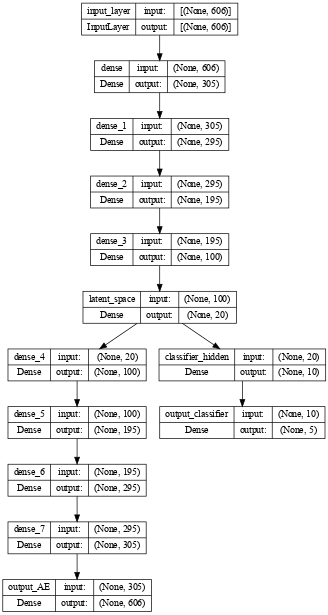

In [9]:
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
tf.keras.utils.plot_model(autoencoder, 
                        to_file='custom_model.png',
                        show_shapes=True,
                        show_layer_names=True,
                        dpi=50,                    
                        rankdir='AB'                 
                    )

## Verificación de Formas de Entrada y Salida del Modelo

In [10]:
print(f"Forma de X_train_ae (input): {X_train_ae.shape}")  # (12408, 606)
print(f"Forma de Y_train_ae (labels): {Y_train_ae.shape}")  # (12408, 1)
print(f"Forma esperada para output_layer: {autoencoder.output[0].shape}")  # (None, 606)
print(f"Forma esperada para classifier_output: {autoencoder.output[1].shape}")  # (None, 1)
autoencoder.output_names

Forma de X_train_ae (input): (27142, 606)
Forma de Y_train_ae (labels): (27142,)
Forma esperada para output_layer: (None, 606)
Forma esperada para classifier_output: (None, 5)


['output_AE', 'output_classifier']

In [11]:
Y_ae = (X_train_ae, Y_train_ae_cod)

# Imprimir información sobre train_y
print("Tamaños de train_y:")
print(f"  Y_ae: {len(Y_ae)}")  
print(f"  Y_train_ae: {Y_ae[0].shape}")    
print(f"  Y_train_ae: {Y_ae[1].shape}")    

Tamaños de train_y:
  Y_ae: 2
  Y_train_ae: (27142, 606)
  Y_train_ae: (27142, 5)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Métrica que se observará (por ejemplo, 'val_loss')
    patience=10,            # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los pesos de la mejor época
)

# Entrenamiento con EarlyStopping
history = autoencoder.fit(
    x=X_train_ae,
    y=Y_ae,
    batch_size=128,
    epochs=100,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping]  # Pasar EarlyStopping en los callbacks
)



Epoch 1/100
170/170 - 3s - loss: 1.4287 - output_AE_loss: 0.0138 - output_classifier_loss: 1.4246 - output_AE_mae: 0.0556 - output_AE_r2_score: 0.9166 - output_classifier_accuracy: 0.3610 - output_classifier_recall: 0.0882 - output_classifier_precision: 0.6951 - output_classifier_auc: 0.6875 - val_loss: 1.2772 - val_output_AE_loss: 0.0027 - val_output_classifier_loss: 1.2764 - val_output_AE_mae: 0.0326 - val_output_AE_r2_score: 0.9837 - val_output_classifier_accuracy: 0.4122 - val_output_classifier_recall: 0.2085 - val_output_classifier_precision: 0.6513 - val_output_classifier_auc: 0.7602 - 3s/epoch - 16ms/step
Epoch 2/100
170/170 - 1s - loss: 1.2644 - output_AE_loss: 0.0027 - output_classifier_loss: 1.2636 - output_AE_mae: 0.0327 - output_AE_r2_score: 0.9833 - output_classifier_accuracy: 0.4294 - output_classifier_recall: 0.1832 - output_classifier_precision: 0.6800 - output_classifier_auc: 0.7637 - val_loss: 1.2394 - val_output_AE_loss: 0.0032 - val_output_classifier_loss: 1.2385 - 

### Evaluación del Modelo Entrenado

In [13]:
# Definir las métricas configuradas en el modelo
metricas = [
    "loss",  # Pérdida total
    "output_AE_loss",  # Pérdida del autoencoder
    "output_classifier_loss",  # Pérdida del clasificador
    "output_AE_mae",  # MAE del autoencoder
    "output_AE_r2_score",  # R2 Score del autoencoder
    "output_classifier_accuracy",  # Exactitud del clasificador
    "output_classifier_recall",  # Recall del clasificador
    "output_classifier_precision",  # Precisión del clasificador
    "output_classifier_auc"  # AUC del clasificador
]

# Evaluar el modelo en el conjunto de entrenamiento
train_metrics = autoencoder.evaluate(
    x=X_train_ae,
    y={"output_AE": X_train_ae, "output_classifier": Y_train_ae_cod},
    verbose=1
)

# Mostrar las métricas
print("\nMétricas del Modelo en el Conjunto de Entrenamiento:")
print("-" * 50)

for nombre, valor in zip(metricas, train_metrics):
    print(f"{nombre}: {valor:.6f}")


from sklearn.metrics import classification_report

# Obtener predicciones en los datos de entrenamiento
predicciones_train = autoencoder.predict(X_train_ae)[1]  # Obtiene las predicciones del clasificador
predicciones_train_clase = predicciones_train.argmax(axis=1)  # Clase con la probabilidad más alta

# Generar el reporte de clasificación
reporte_train = classification_report(Y_train_ae, predicciones_train_clase, target_names=[str(i) for i in range(5)])
print("Reporte de Clasificación - Entrenamiento:")
print(reporte_train)


849/849 [==============================] - 1s 1ms/step - loss: 0.3804 - output_AE_loss: 0.0016 - output_classifier_loss: 0.3799 - output_AE_mae: 0.0253 - output_AE_r2_score: 0.9901 - output_classifier_accuracy: 0.8624 - output_classifier_recall: 0.8318 - output_classifier_precision: 0.8918 - output_classifier_auc: 0.9799

Métricas del Modelo en el Conjunto de Entrenamiento:
--------------------------------------------------
loss: 0.380386
output_AE_loss: 0.001634
output_classifier_loss: 0.379896
output_AE_mae: 0.025349
output_AE_r2_score: 0.990085
output_classifier_accuracy: 0.862390
output_classifier_recall: 0.831774
output_classifier_precision: 0.891768
output_classifier_auc: 0.979881
849/849 [==============================] - 1s 998us/step
Reporte de Clasificación - Entrenamiento:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5392
           1       0.92      0.81      0.86      5442
           2       0.91      0.86      0.8

In [14]:
# Definir los datos de validación
X_val_ae = X_test_ae
Y_val_ae = {"output_AE": X_test_ae, "output_classifier": Y_test_ae_cod}


# Evaluar el modelo en el conjunto de validación
val_metrics = autoencoder.evaluate(x=X_val_ae, y=Y_val_ae, verbose=0)


# Mostrar las métricas de validación en el formato solicitado
print("\nMétricas del Modelo en el Conjunto de Prueba:")
print("-" * 50)
for nombre, valor in zip(metricas, val_metrics):
    print(f"{nombre}: {valor:.6f}")

from sklearn.metrics import classification_report


# Obtener predicciones en los datos de prueba
predicciones_test = autoencoder.predict(X_test_ae)[1]
predicciones_test_clase = predicciones_test.argmax(axis=1)

# Generar el reporte de clasificación
reporte_test = classification_report(Y_test_ae, predicciones_test_clase, target_names=[str(i) for i in range(5)])
print("Reporte de Clasificación - Prueba:")
print(reporte_test)




Métricas del Modelo en el Conjunto de Prueba:
--------------------------------------------------
loss: 0.610147
output_AE_loss: 0.001641
output_classifier_loss: 0.609655
output_AE_mae: 0.025368
output_AE_r2_score: 0.990043
output_classifier_accuracy: 0.779058
output_classifier_recall: 0.744842
output_classifier_precision: 0.812910
output_classifier_auc: 0.952303
182/182 [==============================] - 0s 981us/step
Reporte de Clasificación - Prueba:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1182
           1       0.84      0.75      0.79      1125
           2       0.82      0.77      0.79      1153
           3       0.76      0.76      0.76      1189
           4       0.63      0.75      0.69      1167

    accuracy                           0.78      5816
   macro avg       0.79      0.78      0.78      5816
weighted avg       0.79      0.78      0.78      5816



In [15]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    """
    Grafica una métrica específica del historial de entrenamiento.
    
    Parámetros:
        history (History): El historial de entrenamiento del modelo.
        metric (str): El nombre de la métrica a graficar.
    """
    if metric not in history.history:
        print(f"Métrica '{metric}' no encontrada en el historial.")
        return
    
    epochs = range(1, len(history.history[metric]) + 1)

    # Graficar métrica de entrenamiento
    plt.figure(figsize=(6, 3))
    plt.plot(epochs, history.history[metric], label=f'Train {metric}')
    
    # Graficar métrica de validación si está disponible
    val_metric = f'val_{metric}'
    if val_metric in history.history:
        plt.plot(epochs, history.history[val_metric], label=f'Validation {metric}')
    
    # Configuración del gráfico
    plt.title(f'{metric.replace("_", " ").title()} Vs Epocas')
    plt.xlabel('Epocas')
    plt.ylabel(metric.split("_")[-1].capitalize())  # Usar la última parte como nombre del eje Y
    plt.legend()
    plt.grid()
    plt.show()


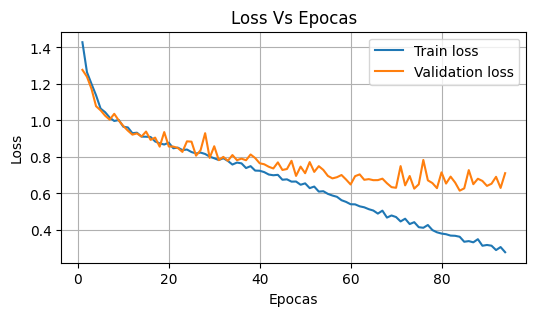

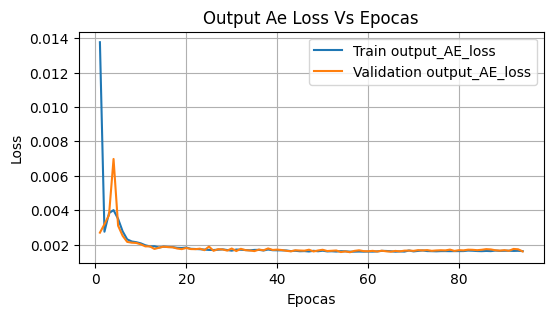

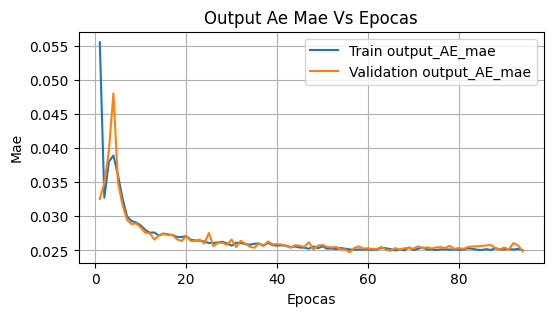

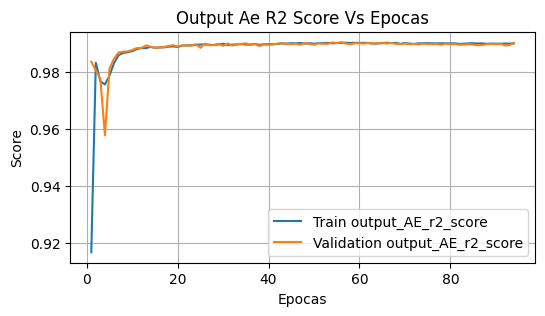

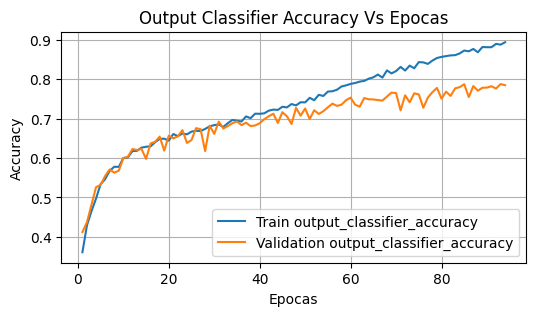

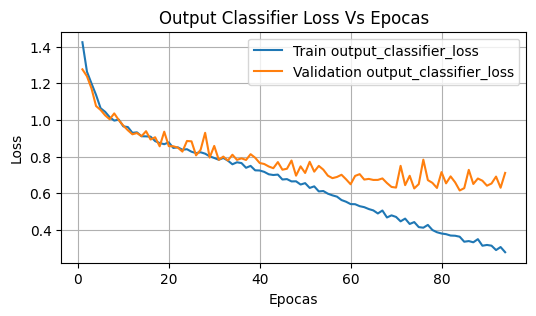

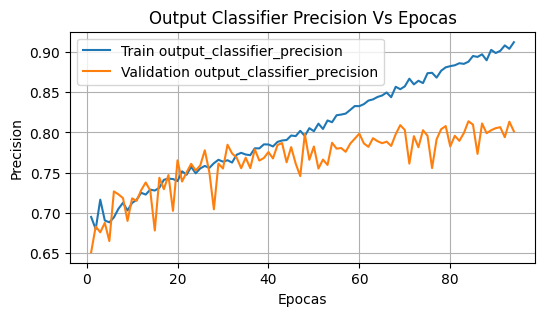

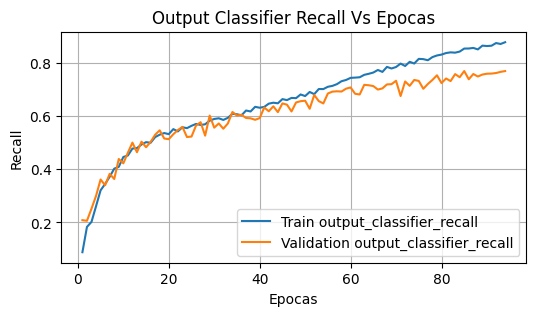

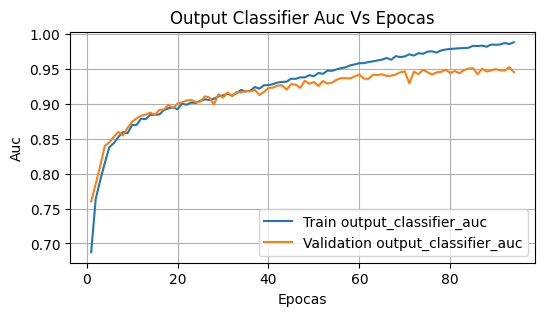

In [16]:
# Llamadas a la función para graficar métricas específicas
plot_metric(history, 'loss')  # Pérdida total
plot_metric(history, 'output_AE_loss')  # Pérdida del autoencoder
plot_metric(history, 'output_AE_mae')  # MAE del autoencoder
plot_metric(history, 'output_AE_r2_score')  # R² Score del autoencoder
plot_metric(history, 'output_classifier_accuracy')  # Precisión del clasificador
plot_metric(history, 'output_classifier_loss')  # Pérdida del clasificador
plot_metric(history, 'output_classifier_precision')  # Precisión del clasificador
plot_metric(history, 'output_classifier_recall')  # Recall del clasificador
plot_metric(history, 'output_classifier_auc')  # AUC del clasificador

In [17]:
# Guardar el modelo reentrenado
autoencoder.save("../Modelos/Multi_AE_MPL_SS.keras")
print("Modelo reentrenado guardado exitosamente.")

Modelo reentrenado guardado exitosamente.


## Visualizacion de recontrucción

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Función para visualizar la reconstrucción de una señal específica
def visualizar_reconstruccion(autoencoder, datos_originales, indice):
    """
    Visualiza una señal original y su reconstrucción realizada por el autoencoder.
    
    Parámetros:
    - autoencoder: El modelo autoencoder entrenado.
    - datos_originales: Conjunto de datos original (DataFrame o array).
    - indice: Índice de la señal a visualizar (fila del conjunto de datos).
    """
    # Asegurarse de que los datos son un array NumPy
    if isinstance(datos_originales, pd.DataFrame):
        datos_originales = datos_originales.values  # Convertir DataFrame a array si es necesario
    
    # Validar el índice
    if indice < 0 or indice >= datos_originales.shape[0]:
        raise ValueError(f"Índice fuera de rango. Debe estar entre 0 y {datos_originales.shape[0] - 1}.")
    
    # Obtener la señal original (fila)
    señal_original = datos_originales[indice]
    
    # Reconstruir la señal usando la salida del autoencoder correspondiente al reconstructor
    reconstrucciones = autoencoder.predict(señal_original.reshape(1, -1), verbose=0)
    señal_reconstruida = reconstrucciones[0]  # La primera salida corresponde a la reconstrucción
    
    # Graficar la señal original y reconstruida
    plt.figure(figsize=(9, 4))
    plt.plot(señal_original, label='Señal Original', color='blue', alpha=0.7, linewidth=2)
    plt.plot(señal_reconstruida.flatten(), label='Señal Reconstruida', color='red', linestyle='dashed', alpha=0.7, linewidth=2)
    plt.title(f"Reconstrucción de la Señal - Índice: {indice}", fontsize=14)
    plt.xlabel("Índice de Característica", fontsize=12)
    plt.ylabel("Valor", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

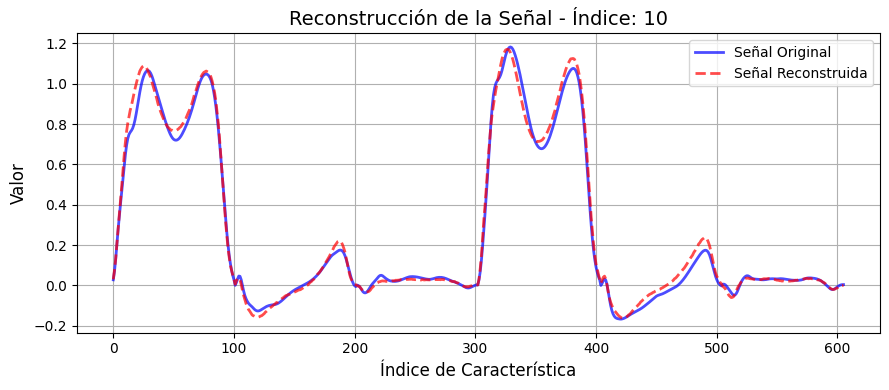

In [19]:


# Seleccionar una señal para visualizar
indice_señal = 10  # Cambia este índice para visualizar otras señales

# Llamar a la función de visualización
visualizar_reconstruccion(autoencoder, X_train_ae, indice_señal)



## Visualizacion de espacios
### Espacio latente

In [20]:
# Crear el encoder como un modelo independiente
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_space').output)

# Generar el espacio latente utilizando el encoder
espacio_latente = encoder.predict(X_train_ae)

# Verificar las dimensiones del espacio latente
print(f"Dimensiones de X_train_ae: {X_train_ae.shape}")
print(f"Dimensiones del espacio latente: {espacio_latente.shape}")


849/849 [==============================] - 1s 623us/step
Dimensiones de X_train_ae: (27142, 606)
Dimensiones del espacio latente: (27142, 20)


In [21]:
# Guardar el encoder
encoder.save("../Modelos/Multi_Encoder_MPL_SS.keras")
print("Encoder guardado exitosamente.")

Encoder guardado exitosamente.


In [22]:

# Reducir el espacio latente a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)


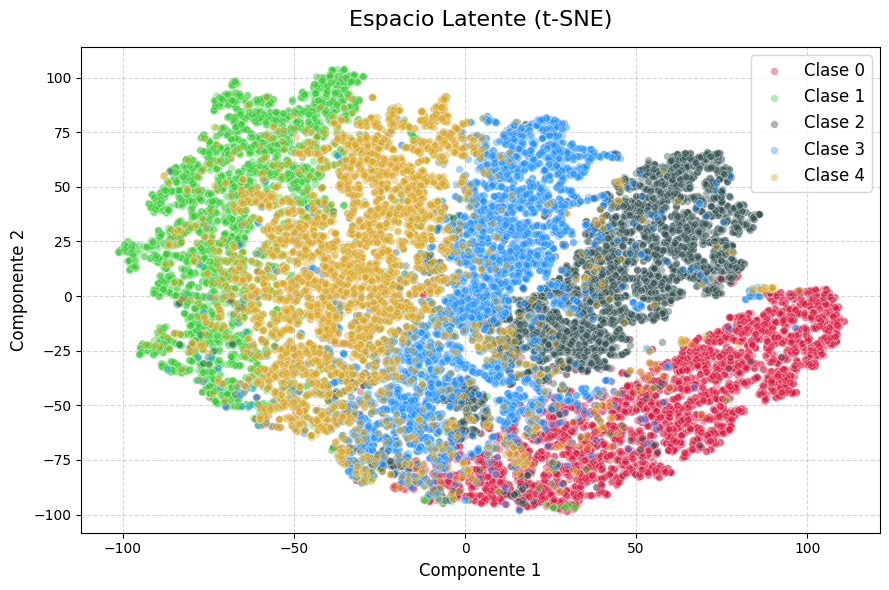

In [23]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['crimson', 'limegreen', 'darkslategray', 'dodgerblue', 'goldenrod']  # Colores sugeridos para las clases

for i, clase in enumerate([0,1,2,3,4]):
    indices = Y_train_ae == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()
